In [2]:
import os
import numpy as np
import pandas as pd
import functools

import geopandas as gpd
import rasterio
from rasterio.enums import Resampling, MergeAlg
from rasterio import features

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from process_functions import *

import sys
os.chdir(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\crop_rotation')

In [1]:
import warnings
warnings.filterwarnings('ignore')

**Zone Labels**

(362, 896)


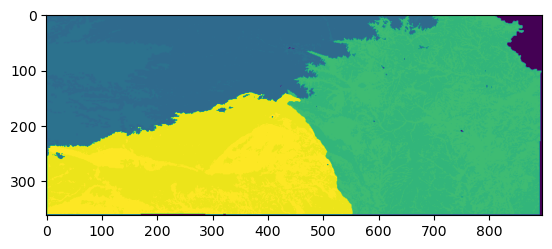

In [3]:
# Cluster Template
cluster = rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/cluster.tif").read(1) 
print(cluster.shape)
new_width = cluster.shape[1]
new_height = cluster.shape[0]
plt.imshow(cluster)

**Crop Insurance Cause of Loss Data**

In [4]:
# Insurance Data
fp= r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/data_processing/final_processing/loss_type_per.shape" # state shape file. 
loss_type = gpd.read_file(fp)
loss_type.to_crs(4326, inplace = True)
print(loss_type.shape==cluster.shape)
loss_type.head(3)

False


,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,Cold Wet W,Cold Winte,Drought,...,Flood,Freeze,Frost,Hail,Heat,Hot Wind,Insects,Plant Dise,Wind/Exces,geometry
0,20,20023,Kansas,cheyenne,05,2.145800,0.277993,0.008199,0.009869,0.493143,...,0.000439,0.036521,0.000000,0.285915,0.038090,0.016051,0.000898,0.012373,0.037265,"POLYGON ((-102.04981 39.57406, -102.04993 39.5..."
1,20,20153,Kansas,rawlins,05,2.213924,0.291303,0.004149,0.004017,0.622200,...,0.000078,0.029575,0.000676,0.139846,0.024056,0.012126,0.000000,0.003003,0.030883,"POLYGON ((-101.41391 39.56832, -101.41361 39.5..."
2,20,20089,Kansas,jewell,05,2.016403,0.249024,0.006806,0.021999,0.584490,...,0.005143,0.063787,0.006200,0.128203,0.021179,0.000459,0.001369,0.001115,0.005777,"POLYGON ((-98.50527 39.56760, -98.50530 39.567..."


In [5]:
# Convert Vector Geopandas to a List of Numpy Arrays in the Same Spatial Domain as Clusters
value_list = ['Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']

loss_list = []
template = rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/cluster.tif")

for i in value_list: 
    geom_value = ((geom,value) for geom, value in zip(loss_type.geometry, loss_type[i]))
    rasterized = features.rasterize(geom_value,
                                out_shape = template.shape,
                                transform = template.transform,
                                all_touched = True,
                                fill = -9999,   # background value
                                merge_alg = MergeAlg.replace,
                                dtype = np.float32)
    loss_list.append(rasterized) 

**Insurance Classifier Data**

In [6]:
# Irrigation Classifier
fp= r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\irrigation_classifier\KS_irrigation_focus2007_applicable2003_2012.shp" # state shape file. 
irr = gpd.read_file(fp)
irr.to_crs(4326, inplace = True)
print(irr.shape==cluster.shape)
print(irr.shape)
irr.head(3)

False
(11209, 3)


,Id,gridcode,geometry
0,1,1,"POLYGON ((-102.03954 39.97937, -102.04046 39.9..."
1,2,1,"POLYGON ((-101.53801 40.00006, -101.54207 40.0..."
2,4,1,"POLYGON ((-101.54528 39.98847, -101.54795 39.9..."


In [7]:
template = rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/cluster.tif")

geom_value = ((geom,value) for geom, value in zip(irr.geometry, irr['gridcode']))
irr_raster = features.rasterize(geom_value,
                            out_shape = template.shape,
                            transform = template.transform,
                            all_touched = True,
                            fill = -9999,   # background value
                            merge_alg = MergeAlg.replace,
                            dtype = np.float32)

True

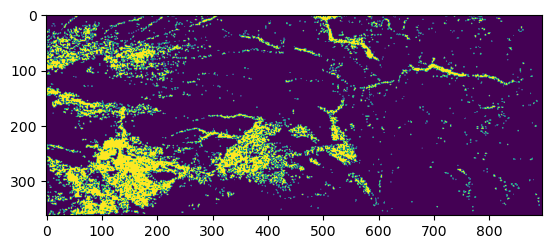

In [8]:
plt.imshow(irr_raster)
irr_raster.shape == cluster.shape

**Crop Frequency Data**

In [9]:
# Crop Rotation Data
ks_2022= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2022wgs84_ks_scaled.tif").read(1)
ks_2021= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2021wgs84_ks_scaled.tif").read(1)
ks_2020= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2020wgs84_ks_scaled.tif").read(1)     
ks_2019= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2019wgs84_ks_scaled.tif").read(1)
ks_2018= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2018wgs84_ks_scaled.tif").read(1)
ks_2017= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2017wgs84_ks_scaled.tif").read(1)
ks_2016= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2016wgs84_ks_scaled.tif").read(1)    
ks_2015= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2015wgs84_ks_scaled.tif").read(1)
ks_2014= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2014wgs84_ks_scaled.tif").read(1)
ks_2013= rasterio.open(r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\code\ks_agro_climate\2013wgs84_ks_scaled.tif").read(1)

rotation = np.stack(( ks_2022, ks_2021, ks_2020, ks_2019, ks_2018, ks_2017, ks_2016, ks_2015, ks_2014, ks_2013))

In [10]:
# Function to mask for specific crop values
def CropCount(np_array, vals):
    mask = functools.reduce(np.logical_or, (np_array==val for val in vals))
    non_crop = (np.where(mask, 1,0)).astype(dtype=np.uint8)
    return non_crop 

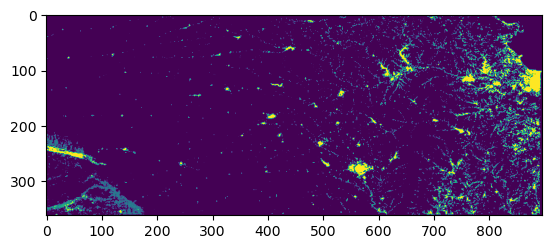

In [11]:
# Create a Boolean for Non crop and Non crop plus grass values for entire period
ks_non_crop = [CropCount(r, [63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 190, 195]) for r in rotation]
ks_non_crop = sum(ks_non_crop)

ks_non_crop_grass = [CropCount(r, [63, 64, 65, 111,112, 121, 122, 123, 124, 131, 141, 142, 143, 152, 176,  190, 195]) for r in rotation]
ks_non_crop_grass= sum(ks_non_crop_grass)
plt.imshow(ks_non_crop)

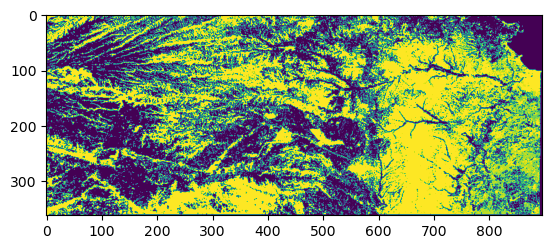

In [12]:
plt.imshow(ks_non_crop_grass)

In [13]:
# Get top 10 crops by area
mask = (ks_non_crop >= 1) 
unique, counts = np.unique(ks_2022[~mask], return_counts=True)
unq = pd.DataFrame(counts,unique)
unq.sort_values(by=[0], ascending=False).head(12)

,0
176.0,147975
24.0,38918
1.0,35485
5.0,27043
61.0,17756
4.0,15631
0.0,6884
26.0,3839
36.0,2596
2.0,566


In [14]:
# Calculate refrequency of crop planted for the 10 year period
wheat = [CropCount(r, [24]) for r in rotation]
wheat = sum(wheat)

corn = [CropCount(r, [1]) for r in rotation]
corn = sum(corn)

soybeans = [CropCount(r, [5]) for r in rotation]
soybeans = sum(soybeans)

fallow = [CropCount(r, [61]) for r in rotation]
fallow = sum(fallow)

sorghum = [CropCount(r, [4]) for r in rotation]
sorghum = sum(sorghum)

wht_soy = [CropCount(r, [26]) for r in rotation]
wht_soy= sum(wht_soy)

alfalfa = [CropCount(r, [36]) for r in rotation]
alfalfa= sum(alfalfa)

other_hay = [CropCount(r, [37]) for r in rotation]
other_hay= sum(other_hay)

triticale = [CropCount(r, [205]) for r in rotation]
triticale= sum(triticale)

cotton = [CropCount(r, [2]) for r in rotation]
cotton= sum(cotton)

grassland = [CropCount(r, [176]) for r in rotation]
grassland = sum(grassland)

**Validation Data Set**

In [15]:
# Create mask 
mask_macro = (cluster == 0) | (ks_non_crop == 1) |(loss_list[0] ==-9999) |(irr_raster ==1)

cluster_m = cluster[~mask_macro]

crop_features =[wheat, corn, soybeans, fallow, sorghum, wht_soy, alfalfa, other_hay, triticale, cotton, grassland]
feature_list = crop_features+loss_list
crop_features_m = [f[~mask_macro] for f in feature_list]

In [16]:
# Count observations in each macro cluster 
np.unique(np.round(cluster/10, 0), return_counts=True)

(array([0., 1., 2., 3.]), array([  8169,  98810, 130469,  86904], dtype=int64))

In [17]:
sums=98810+130469+86904
print('NW', np.round(98810/sums, 3), (98810*(800*800))/1000000 )
print('E', np.round(130469/sums, 3), (130469*(800*800))/1000000 )
print('SW', np.round(86904/sums, 3), (86904*(800*800))/1000000 )

NW 0.313 63238.4
E 0.413 83500.16
SW 0.275 55618.56


In [18]:
total_area = sum(unq.sort_values(by=[0], ascending=False).head(10)[0])*(800*800) #800m raster
total_hectares = total_area/10000
total_hectares 

18988352.0

In [19]:
NW_area = (85588*(800*800))/10000 
E_area = (121547*(800*800))/10000 
SW_area = (60796*(800*800))/10000 

**Function for Multinomial Logistic Regression**

In [22]:
# This is list is masked to determine what features where retained by the gridsearch pipeline
features = ['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wht_soy', 'alfalfa', 
            'other_hay', 'triticale', 'cotton', 'grassland', 'Cold Wet W', 'Cold Winte', 'Drought', 
            'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']


def MultiNomial (x,y, indices, class_weights, empty_dic):
    X_train, X_test, y_train, y_test,indices_train, indices_test= train_test_split(X, y, indices, test_size=0.25, random_state=2, stratify=y)
   
    empty_dic['indices_train'] = indices_train
    empty_dic['indices_test'] = indices_test
    
    # Select Optimal Model Parameters 
    pipeline  =  Pipeline(steps=[('scaler', MinMaxScaler()), ('selector', SelectKBest(mutual_info_classif)),('classifier', LogisticRegression(random_state=42))])
    
    cv = 10

    # Set Paramters
    parameters = [{'selector__score_func': [mutual_info_classif, f_classif, chi2] , 
                   'selector__k':[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]},
                  {'classifier__penalty' : ['l2',  'none'],
                  'classifier__solver' : ['lbfgs',  'newton-cg', 'sag', 'saga'],
                  'classifier__max_iter':[500, 1000],
                  'classifier__multi_class':['multinomial'], 
                  'classifier__class_weight':[class_weight], 
                 }]
    
    params_ = GridSearchCV(estimator=pipeline, param_grid = parameters, cv = cv, n_jobs=-1)
    params_.fit(X_train, y_train)
    print(params_.best_params_)
    empty_dic['parameters'] = params_.best_params_
    empty_dic['estimator'] = params_.best_estimator_
    
    empty_dic['feature_mask']= params_.best_estimator_.named_steps['selector'].get_support()
    empty_dic['features'] = [m for f, m in zip(empty_dic['feature_mask'], features) if f]
    print(empty_dic['features'])
    
   # Evaluate Model
    scores = cross_validate(params_.best_estimator_.set_params(), X_test, y_test, cv = 10, 
               scoring=['r2', 'neg_mean_squared_error', 'accuracy', 'mutual_info_score'])
       
    for key,vals in scores.items():
        print("Average for {} is {}".format(key,round(np.mean(vals),2)))
    empty_dic['scores'] = scores
        
    # Classification Report 
    logmodel = params_.best_estimator_.set_params() #LogisticRegression(**params_.best_params_, random_state=2) 
    logmodel.fit(X_train, y_train)

    predictions=logmodel.predict(X_test)
    empty_dic['y_trues'] = y_test
    empty_dic['y_preds']=  predictions
    empty_dic['model'] = logmodel 
    empty_dic['feature_coefficients']= logmodel.named_steps["classifier"].coef_.flatten()
    
    print(classification_report(y_test,  predictions))

**Macro Zone Validation**

In [23]:
y = np.round(cluster_m/10,0) # reduce to classes 1, 2, 3
y = y.astype(int).astype(str) # change to categorical variable 

class_weight = {'1':np.count_nonzero(y== '1')/np.count_nonzero(y),'2':np.count_nonzero(y== '2')/np.count_nonzero(y), '3':np.count_nonzero(y== '3')/np.count_nonzero(y)} # class weights

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

macro_results = {}

MultiNomial (X,y, indices, class_weight, macro_results)

{'selector__k': 23, 'selector__score_func': <function mutual_info_classif at 0x00000241DD1B4318>}
['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wht_soy', 'other_hay', 'triticale', 'cotton', 'grassland', 'Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']
Average for fit_time is 535.3
Average for score_time is 0.03
Average for test_r2 is 0.47
Average for test_neg_mean_squared_error is -0.28
Average for test_accuracy is 0.88
Average for test_mutual_info_score is 0.63
              precision    recall  f1-score   support

           1       0.89      0.88      0.89     21397
           2       0.91      0.96      0.93     30387
           3       0.81      0.74      0.77     15199

    accuracy                           0.88     66983
   macro avg       0.87      0.86      0.86     66983
weighted avg       0.88      0.88      0.88     66983



In [24]:
# Assign dataframe value 
macro_results['y_preds']
macro_results['y_trues']

array(['2', '2', '3', ..., '1', '1', '3'], dtype='<U11')

In [25]:
# Merge Back with Cluster For Plotting 
pred_array =np.full(y.shape,  -9999)
true_array =np.full(y.shape,  -9999)
test_inds = tuple(zip(* macro_results['indices_test']))#tuple(zip(*indices_test))
train_inds = tuple(zip(* macro_results['indices_train']))#tuple(zip(*indices_train))

pred_array[test_inds]=  macro_results['y_preds'] #predictions_log_macro 
pred_array[train_inds]=  -9999

true_array[test_inds]= macro_results['y_trues']#y_test
true_array[train_inds]=  -9999

pred_macro =np.full(cluster.shape, -9999)
actual_macro =np.full(cluster.shape,  -9999)

mask_idx = np.argwhere(mask_macro==False)
mask_idx= tuple(zip(*mask_idx))

pred_macro[mask_idx] =  pred_array.astype(int)
actual_macro[mask_idx] =  true_array.astype(int)

In [26]:
# Write to Raster Files 

# Macro Predictions
file_str= r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/pred_macro.tif'
rasterfn = r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/cluster.tif"
array = pred_macro
array2raster(file_str,rasterfn,array)

# Macro Ground Truth
file_str= r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/actual_macro.tif'
rasterfn = r"C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp/agroecology_paper/agroforestry/cluster.tif"
array = actual_macro
array2raster(file_str,rasterfn,array)

**Macro-Micro Zone Validation**

In [28]:
#This includes grassland as a variable 

y = cluster_m.astype(int).astype(str) # change to categorical variable 

class_weight = {'11':np.count_nonzero(y== '11')/np.count_nonzero(y),'12':np.count_nonzero(y== '12')/np.count_nonzero(y), 
                '21':np.count_nonzero(y== '21')/np.count_nonzero(y),  '22':np.count_nonzero(y== '22')/np.count_nonzero(y), 
                '31':np.count_nonzero(y== '31')/np.count_nonzero(y),  '32':np.count_nonzero(y== '32')/np.count_nonzero(y), } # class weights

indices = [x for x,i in np.ndenumerate(y)] # This is used for plotting

# This includes grassland w/24 variables
X = np.stack((crop_features_m[0].flatten(),crop_features_m[1].flatten(),crop_features_m[2].flatten(),crop_features_m[3].flatten(), crop_features_m[4].flatten(), crop_features_m[5].flatten(), 
              crop_features_m[6].flatten(), crop_features_m[7].flatten(), crop_features_m[8].flatten(),crop_features_m[9].flatten(), crop_features_m[10].flatten(), crop_features_m[11].flatten(), 
              crop_features_m[12].flatten(), crop_features_m[13].flatten(), crop_features_m[14].flatten(),crop_features_m[15].flatten(), crop_features_m[16].flatten(), crop_features_m[17].flatten(), 
               crop_features_m[18].flatten(), crop_features_m[19].flatten(), crop_features_m[20].flatten(),crop_features_m[21].flatten(), crop_features_m[22].flatten(), crop_features_m[23].flatten()), axis=1)

macro_micro_results = {}

MultiNomial (X,y, indices,  class_weight, macro_micro_results)

{'selector__k': 24, 'selector__score_func': <function mutual_info_classif at 0x00000241DD1B4318>}
['wheat', 'corn', 'soybeans', 'fallow', 'sorghum', 'wht_soy', 'alfalfa', 'other_hay', 'triticale', 'cotton', 'grassland', 'Cold Wet W', 'Cold Winte', 'Drought', 'Excess Moi', 'Flood', 'Freeze', 'Frost', 'Hail', 'Heat', 'Hot Wind', 'Insects', 'Plant Dise', 'Wind/Exces']
Average for fit_time is 14.4
Average for score_time is 0.03
Average for test_r2 is 0.56
Average for test_neg_mean_squared_error is -24.11
Average for test_accuracy is 0.66
Average for test_mutual_info_score is 0.77
              precision    recall  f1-score   support

          11       0.79      0.84      0.82     15783
          12       0.74      0.64      0.69      5614
          21       0.58      0.70      0.63     15769
          22       0.61      0.55      0.58     14618
          31       0.64      0.68      0.66     10341
          32       0.62      0.32      0.42      4858

    accuracy                         